<a href="https://colab.research.google.com/github/rnjsdn12332/GAN_study/blob/main/0628_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

GAN 훈련 과정 3단계

1. 판별기를 실제 데이터로 훈련
2. 판별기를 생성된 데이터로 훈련
3. 판별기를 속일 수 있도록 생성기 훈련

**1010 패턴**

In [1]:
import torch
import torch.nn as nn

import pandas
import matplotlib.pyplot as plt

In [3]:
import random

#실제 데이터 생성
def generate_real() :
    real_data = torch.FloatTensor([random.uniform(0.8,1.0),
                                   random.uniform(0.0,0.2),
                                   random.uniform(0.8,1.0),
                                   random.uniform(0.0,0.2)])
    return real_data

generate_real()

tensor([0.8474, 0.0353, 0.9005, 0.1564])

In [10]:
#판별기 생성

class Discriminator(nn.Module) :

    def __init__(self) :
        super().__init__()

        #신경망 레이어 정의
        self.model=nn.Sequential(
            nn.Linear(4,3),
            nn.Sigmoid(),
            nn.Linear(3,1),
            nn.Sigmoid()
        )

        #손실함수 설정
        self.loss_function=nn.MSELoss()

        #SGD옵티마이저 설정
        self.optimiser=torch.optim.SGD(self.parameters(), lr=0.01)

        #진행 측정을 위한 변수 초기화
        self.counter=0
        self.progress=[]

        pass
    def forward(self, inputs) :
        #모델 실행
        return self.model(inputs)
        
    def train(self, inputs, targets) :
        #신경망 출력 계산
        outputs=self.forward(inputs)
        
        loss=self.loss_function(outputs, targets)

        self.counter+=1
        if(self.counter % 10 == 0) :
            self.progress.append(loss.item())
            pass
        if(self.counter % 10000 == 0) :
            print("counter = ", self.counter)
            pass
        #기울기를 초기화하고 역전파 후 가중치 갱신

        self.optimiser.zero_grad()
        loss.backward()
        self.optimiser.step()

        pass
    def plot_progress(self) :
        df = pandas.DataFrame(self.progress, columns=['loss'])
        df.plot(ylim=(0,1.0), figsize=(16,8), alpha=0.1, marker='.', grid=True, yticks=(0, 0.25, 0.5))

In [11]:
#판별기 테스트

def generate_random(size) :
    random_data=torch.rand(size)
    return random_data


D=Discriminator()

for i in range(10000) :
    D.train(generate_real(), torch.FloatTensor([1.0]))
    D.train(generate_random(4), torch.FloatTensor([0.0]))
    pass

counter =  10000
counter =  20000


generate_real()에서 얻은 실제 데이터의 1010 패턴을 탐지 했을 때 결과로 1.0 출력하도록 훈련, generate_random()으로 생성된 가짜 데이터는 0.0을 출력하도록 출력하도록 장려함




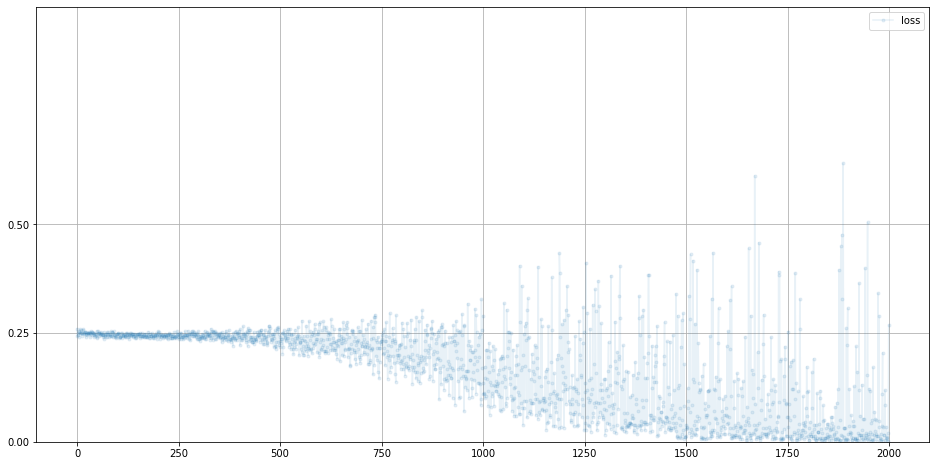

In [12]:
D.plot_progress()

In [13]:
#판별기가 잘 작동하는지 확인
print( D.forward( generate_real()).item() )
print( D.forward( generate_random(4) ). item())

0.803713858127594
0.13338316977024078


In [44]:
# 생성기 생성

class Generator(nn.Module) : 
    def __init__(self) :
        
        super().__init__()

        #신경망 레이어 정의
        self.model=nn.Sequential(
            nn.Linear(1,3),
            nn.Sigmoid(),
            nn.Linear(3,4),
            nn.Sigmoid()
        )

        #SGD옵티마이저 설정
        self.optimiser=torch.optim.SGD(self.parameters(), lr=0.01)

        #진행 측정을 위한 변수 초기화
        self.counter=0
        self.progress=[]

        pass
    def forward(self, inputs) :
        #모델 실행
        return self.model(inputs)

    
    def train(self, D, inputs, targets) :
         
        #신경망 출력 계산
        g_output=self.forward(inputs)

        #판별기로 전달
        d_output = D.forward(g_output)

        
        #오차 계산
        loss=D.loss_function(d_output, targets)

        self.counter+=1
        if(self.counter % 10 == 0) :
            self.progress.append(loss.item())
            pass
    
        #기울기를 초기화하고 역전파 후 가중치 갱신

        self.optimiser.zero_grad()
        loss.backward()
        self.optimiser.step()

        pass
        
    def plot_progress(self) :

        df = pandas.DataFrame(self.progress, columns=['loss'])
        df.plot(ylim=(0,1.0), figsize=(16,8), alpha=0.1, marker='.', grid=True, yticks=(0, 0.25, 0.5))

    

판별기와 다른 점 

init 

1.레이어 갯수 설정 반대로

2.손실 함수 정의 없어도 됌

train

1.생성기의 출력인 g_output은 D.forward(g_output)을 통해 판별기의 신경망에 전달되며 결과로 d_ourtput이 나옴 
2. d_output과 목표값 간의 차이 계산, 이 손실로부터 오차가 역전파되며 판별기에서 생성기로 전달
3. 이 업데이트는 생성기의 가중치만 업데이트함


In [29]:
#훈련되지 않은 생성기
G=Generator()
G.forward(torch.FloatTensor([0.5]))


tensor([0.4612, 0.4760, 0.3677, 0.3190], grad_fn=<SigmoidBackward>)

In [48]:
#판별기 및 생성기 생성

D=Discriminator()
G=Generator()

image_list=[]

#판별기와 생성기 훈련

for i in range(10000) :
    #1단계 : 참에 대해 판별기 훈련
    D.train(generate_real(), torch.FloatTensor([1.0]))

    #2단계 : 거짓에 대한 판별기 훈련
    #G의 기울기가 계산되지 않도록 detach()함수 사용
    D.train(G.forward(torch.FloatTensor([0.5])).detach(), torch.FloatTensor([0.0]))

    #3단계 : 생성기 훈련
    G.train(D, torch.FloatTensor([0.5]), torch.FloatTensor([1.0]))
    
    if (i%1000 == 0) :
        image_list.append(G.forward(torch.FloatTensor([0.5])).detach().numpy())

    pass

counter =  10000
counter =  20000


1단계에서 판별기가 실제 데이터에 대해 훈련

2단계에서 생성기에서 비롯된 패턴을 통해 판별기를 학습
detach()는 생성기의 출력에 적용되어 계산 그래프에서 생성기를 떼어내는 역할을 함
판별기를 훈련하므로 생성기의 기울기를 계산할 필요가 없음
해봤자 시간소요->악영향 없지만 효율을 위해

3단계 생성기 훈련하고 생성기의 입력값은 0.5로 설정한 후 판별기 객체에 전달함.
오차가 판별기로부터 생성기까지 전해지기 떄문에 detach()를 안씀
생성기의 가중치만 업데이트할 뿐이므로 판별기에선 작업이 이루어지지 않는다.

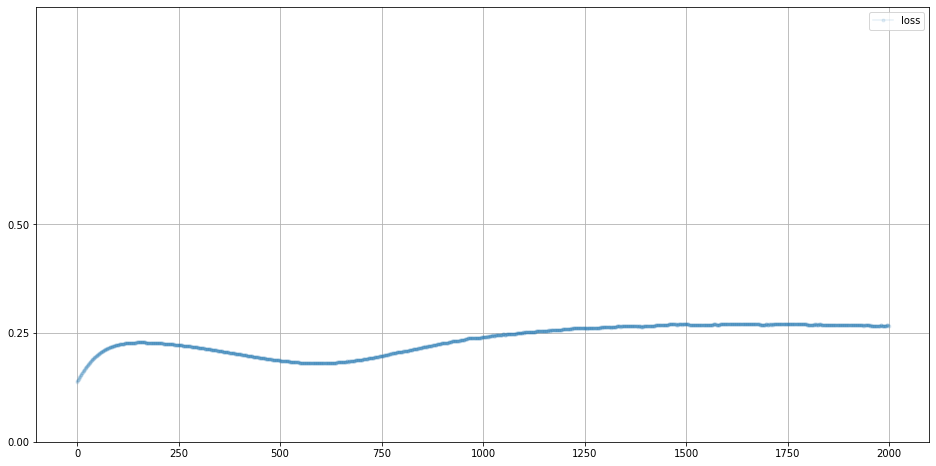

In [38]:
D.plot_progress()

중간에 손실이 조금 떨어지다가 0.25로 올라간 것은 생성기가 판별기가 구별하기 쉽지 않은 데이터를 만들어내기 시작했다는 뜻

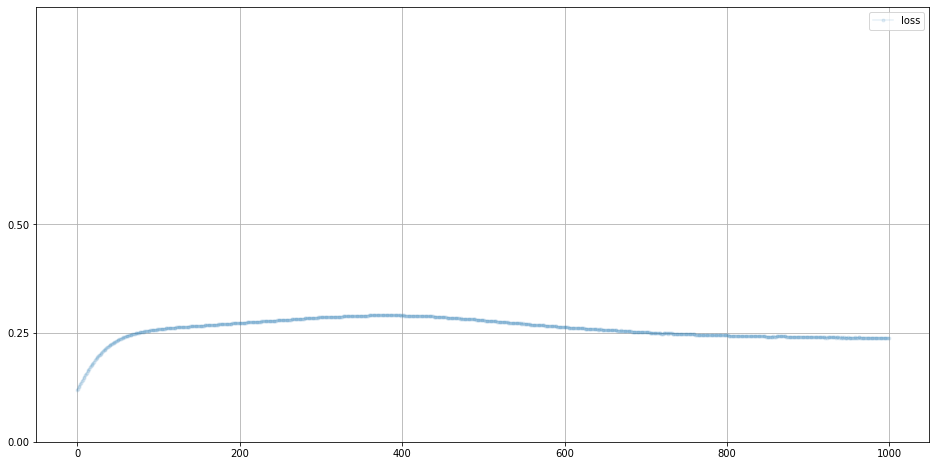

In [46]:
G.plot_progress()

초반에는 판별기가 가짜인지 진짜인지 잘 분류를 못하는 현상을 확인할 수 있고, 중반에는 생성기가 어느정도 판별기를 속일 수 있을 정도로 성능이 향상했음.
훈련의 마지막엔 판별기와 생성기 간에 균형이 생긴 것을 확인할 수 있음.

In [47]:
G.forward(torch.FloatTensor([0.5])) #생성기가 1010패턴 만들었다는걸 확인할 수 있음

tensor([0.9167, 0.0480, 0.9240, 0.0472], grad_fn=<SigmoidBackward>)

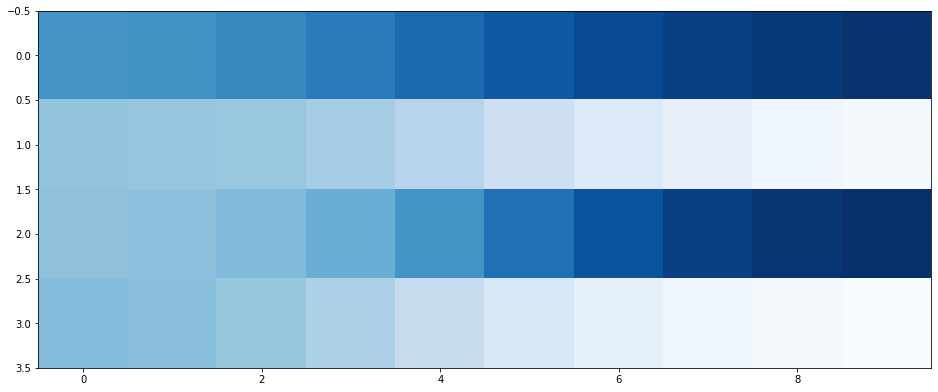

In [50]:
import numpy
plt.figure(figsize = (16,8))
plt.imshow(numpy.array(image_list).T, interpolation='none', cmap='Blues')